In [1]:
import qdmpy.io as Qio
import qdmpy.fit as Qfit
import qdmpy.plot as Qplot
import qdmpy.field as Qfield
import qdmpy.source as Qsource

import matplotlib

In [2]:
# '%matplotlib widget' allows interactive plots in jupyterlab
# use ''%matplotlib inline' to allow export to pdf
# %matplotlib widget

### Load raw data

In [3]:
options_dict = {
    "base_dir": "C:\\ExperimentalData\\2020\\2020-01\\2020-01-13_Diamond353_magnetite\\",
    "filepath": "ODMR - Pulsed_11",
    "custom_output_dir_suffix": "_{fit_backend}_{ROI}_bin_{total_bin}",
    
    "additional_bins": 8,
    
    "exp_reference_type": "field",
    "plot_bnv_flip_with_bias_mag": False,
    
    "system_name": "Cryo_Widefield",

    "ROI": "Full", 
    "ROI_start": [0, 128],
    "ROI_end": [512,384],
    
    "AOI_1_start": [30, 40],
    "AOI_1_end": [40, 45], 
    "AOI_2_start": [20, 20],
    "AOI_2_end": [24, 24], 
    "AOI_3_start": [30, 20],
    "AOI_3_end": [32, 24], 
    "single_pixel_check": [90, 150],
    
    "fit_backend": "scipyfit",
    "fit_backend_comparison": ["scipyfit"],
    "fit_pixels": True, 
    "force_fit": False, 
    
    "use_ROI_avg_fit_res_for_all_pixels": True,
    
    "scipyfit_sub_threads": 2, 

    "fit_functions":  {"linear": 1, "lorentzian": 2},

    "pos_guess": [2600, 3175],
    "pos_range": 25,

    "amp_guess": -0.015,
    "amp_bounds": [-0.300, -0.00003],
    
    "save_fig_type": "pdf",
    
    "freqs_to_use": [1, 0, 0, 0, 0, 0, 0, 1],
    "diamond_ori": "<100>_<100>", # HPHT
    
    "auto_read_bias": True,
    "bias_mag": 50,
    "bias_theta": 45,
    "bias_phi": 125, # 45
    
    "calc_field_pixels": True,
    "force_field_calc": True,
    
    "bfield_bground_method": "poly",
    "bfield_bground_params": {
        "order": 1
    },
    "bnv_bground_method": "poly",
    "bnv_bground_params": {
        "order": 1
    },
    "source_bground_method": None,
    "source_bground_params": {
        "order": 2
    },
    "standoff": 100e-9,
    "NVs_above_sample": True,
    
    
    "colormap_range_dicts": {
        "bnv_images": {
            "type": "percentile",
            "values": [2, 98]
        },
        "bfield_images": {
            "type": "percentile",
            "values": [2, 98]
        },
        "magnetisation_images": {
            "type": "percentile",
            "values": [2, 98]
        },
        "residual_images": {
            "type": "percentile",
            "values": [2, 98]
        },
        "sigma_images": {
            "type": "percentile",
            "values": [2, 98]
        },
        "param_images": {
            "type": "percentile",
            "values": [2, 98]
        },
        "dshift_images": {
            "type": "percentile",
            "values": [2, 98]
        },
    }
}
# if you want to use a reference experiment {ensure you run this even if 'None' as it sets up output dirs etc.}
ref_options_dir = None

In [4]:
options = Qio.load_options(options_dict=options_dict, check_for_prev_result=True)
Qplot.set_mpl_rcparams(options)

### Load data

C:\ProgramData\Miniconda3\lib\site-packages\qdmpy\io\raw.py:322: UserWarning: Avoiding IndexError for single_pixel_check (setting pixel check to centre of image):
index 150 is out of bounds for axis 1 with size 128
  warnings.warn(


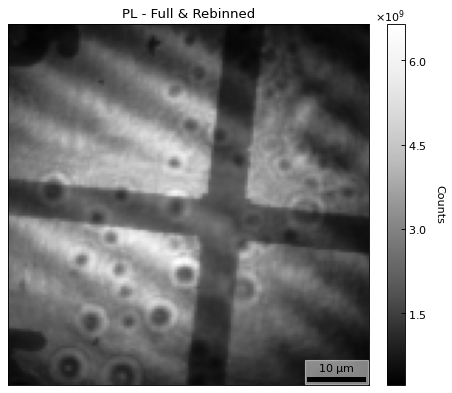

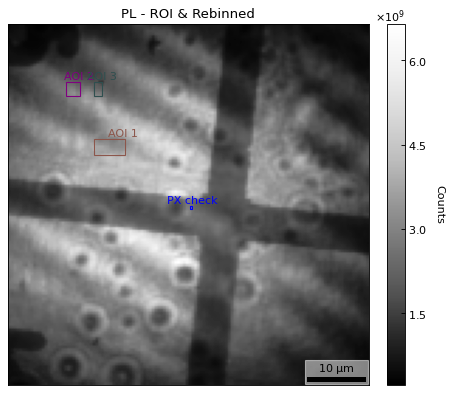

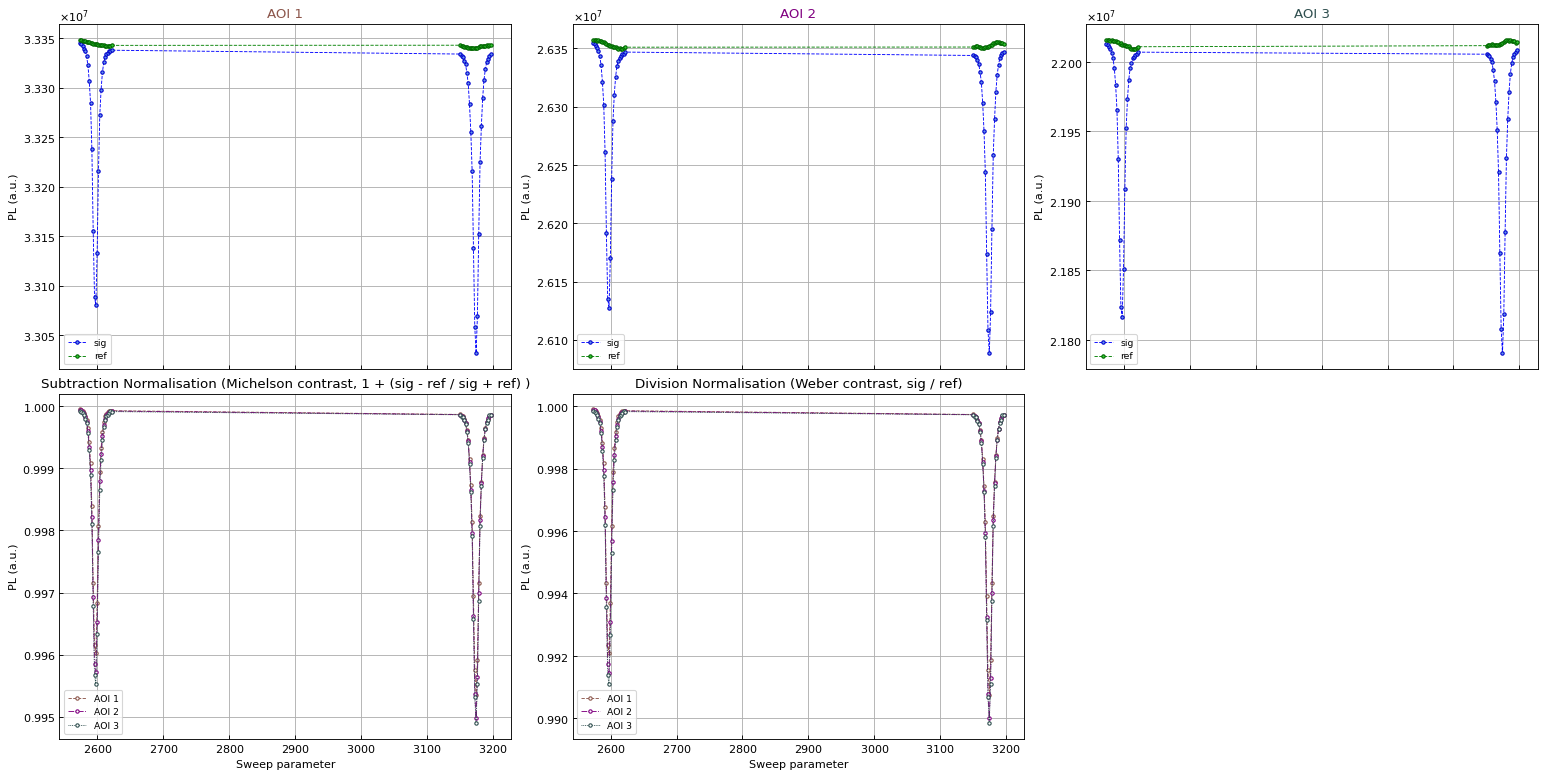

In [5]:
image, prelim_sweep_list = Qio.load_image_and_sweep(options)
PL_image, PL_image_ROI, sig, ref, sig_norm, single_pixel_pl, sweep_list, ROI = Qio.reshape_dataset(
        options, image, prelim_sweep_list
    )
ROI_PL_fig = Qplot.plot_ROI_PL_image(options, PL_image)

AOI_PL_fig = Qplot.plot_AOI_PL_images(options, PL_image_ROI)

AOI_spectra_fig = Qplot.plot_AOI_spectra(options, sig, ref, sweep_list)

Qio.save_PL_data(options, PL_image, PL_image_ROI)

### Load reference experiment - note, you can fit in this same notebook!

In [6]:
# below: alternative is to just have the dictionary already loaded (above this is called `pixel_fit_params`)
ref_fit_params, ref_sigmas = Qio.load_reference_experiment_fit_results(options, ref_options=None, ref_options_dir=ref_options_dir)

C:\ProgramData\Miniconda3\lib\site-packages\qdmpy\io\fit.py:172: UserWarning: Continuing without reference. (No reference chosen or exp_referece_type was 'None')
  warnings.warn(


### Fit AOI, ROI averages, single pixel

C:\ProgramData\Miniconda3\lib\site-packages\qdmpy\fit\_scipyfit.py:35: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm  # auto detects jupyter


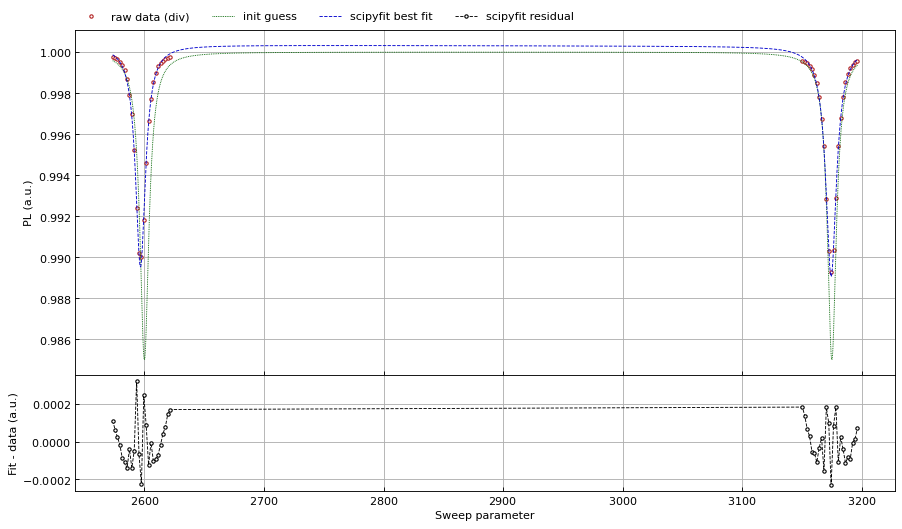

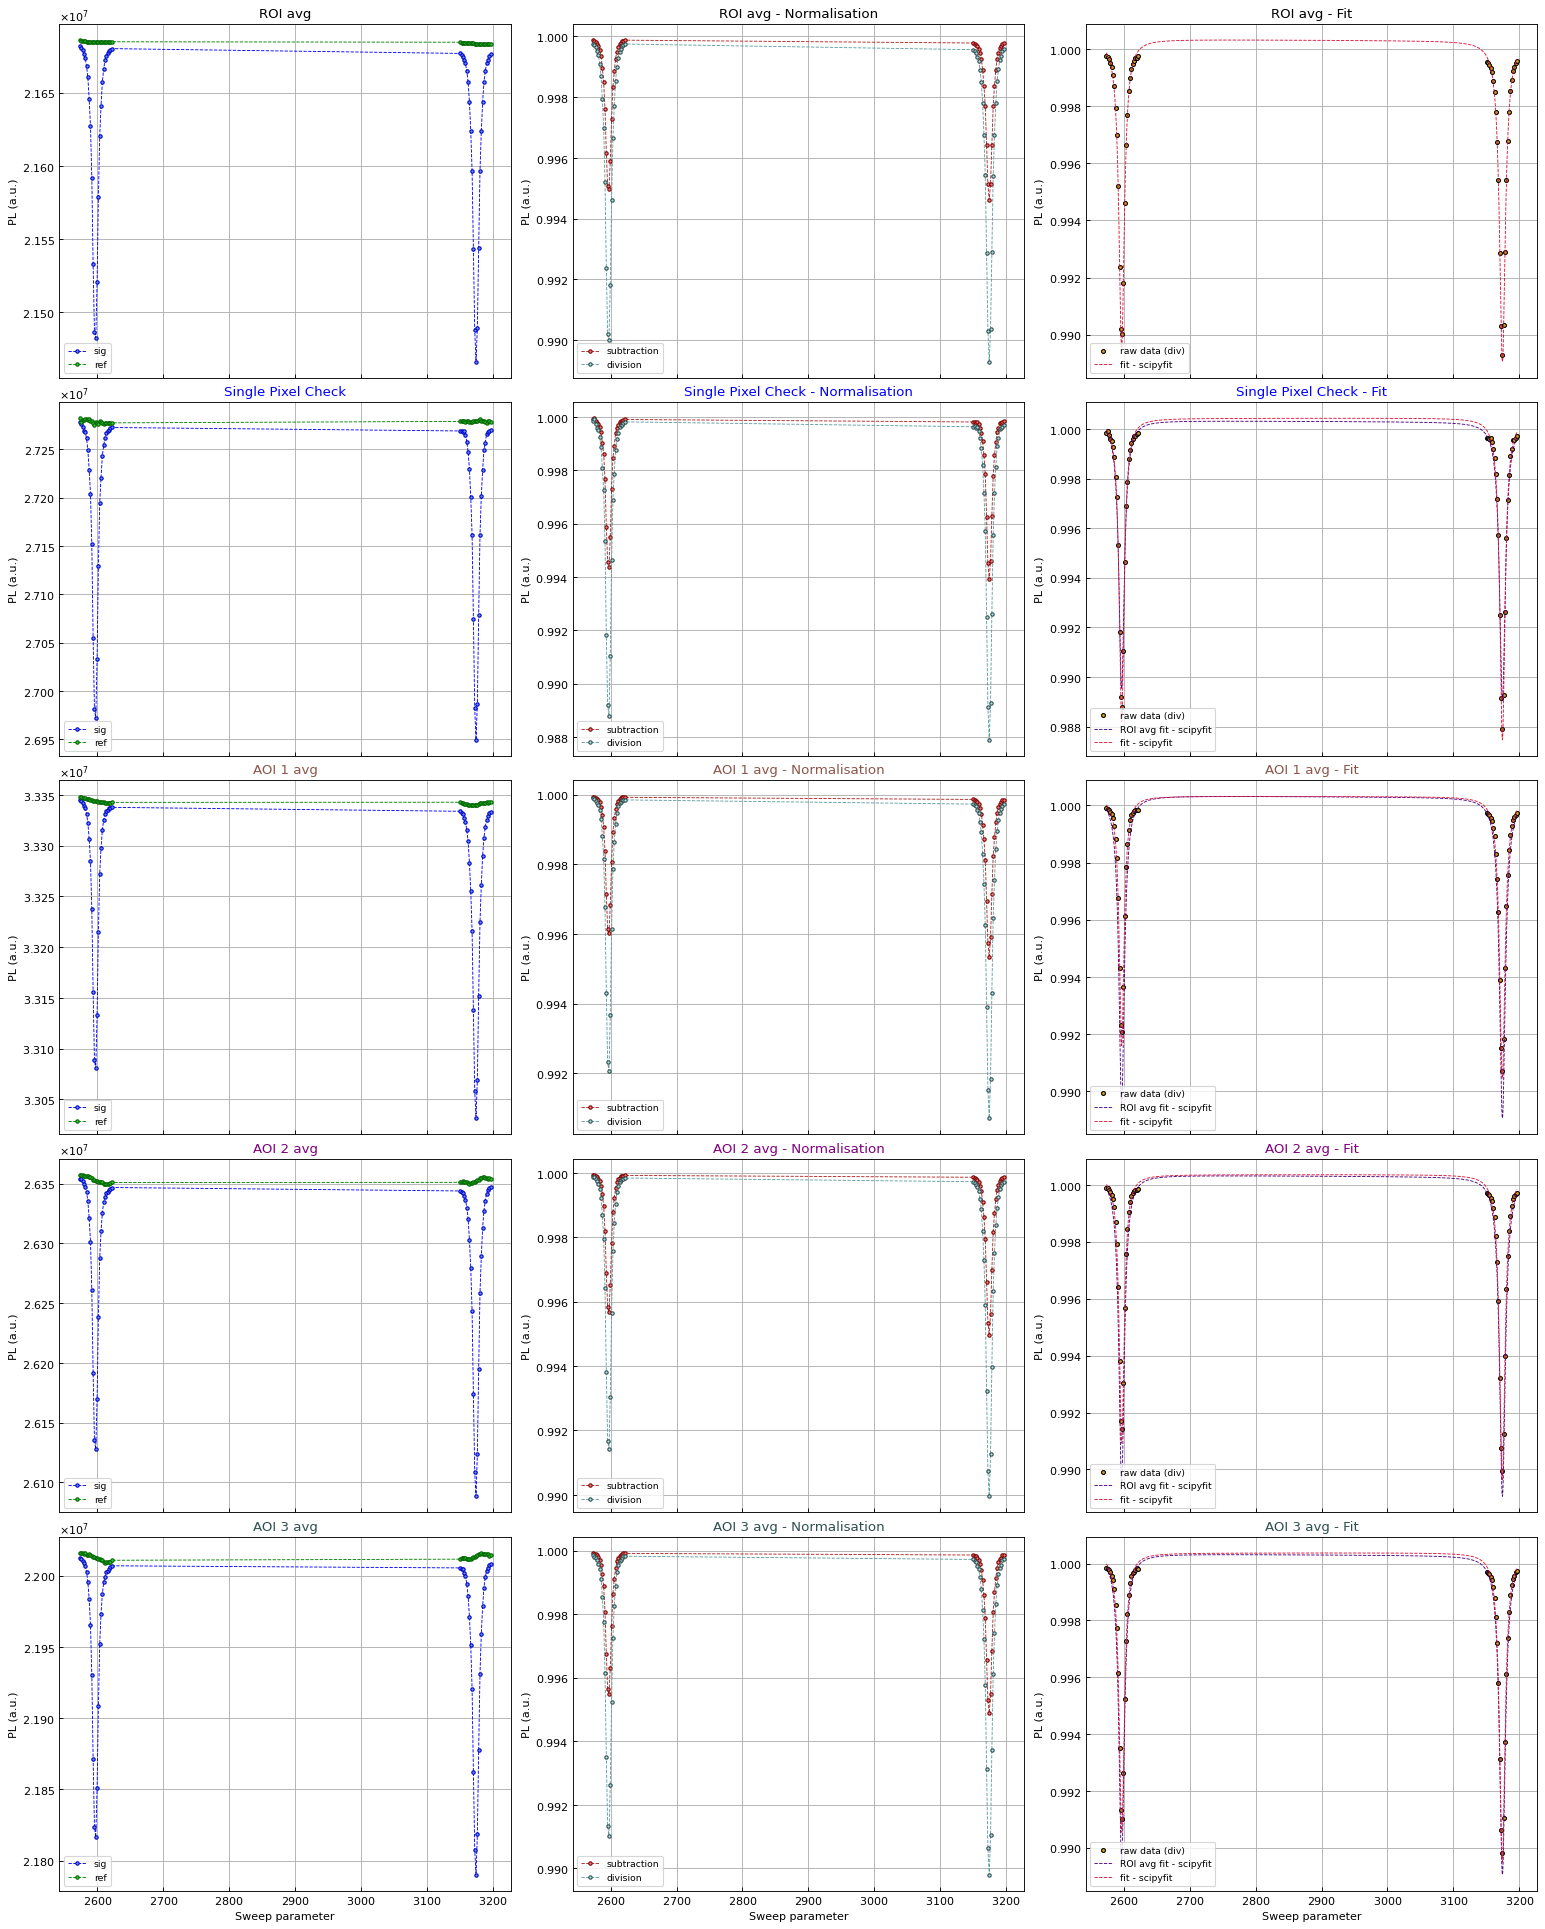

In [7]:
fit_model = Qfit.define_fit_model(options)
backend_ROI_results_lst = Qfit.fit_ROI_avg(options, sig_norm, sweep_list, fit_model)
ROI_fit_fig = Qplot.plot_ROI_avg_fits(options, backend_ROI_results_lst)

fit_result_collection_lst = Qfit.fit_AOIs(options, sig_norm, single_pixel_pl, sweep_list, fit_model, backend_ROI_results_lst)
AOI_fit_fig = Qplot.plot_AOI_spectra_fit(options, sig, ref, sweep_list, fit_result_collection_lst, fit_model)

### Fit pixels

In [8]:
wanted_roi_result = next(
    filter(
        lambda result: result.fit_backend == options["fit_backend"], backend_ROI_results_lst
    )
) # ROI fit result for chosen fit backend
pixel_fit_params, sigmas = Qfit.get_PL_fit_result(options, sig_norm, sweep_list, fit_model, wanted_roi_result)

Qio.save_pixel_fit_results(options, pixel_fit_params)
Qio.save_pixel_fit_sigmas(options, sigmas)

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

### Plot (fit) parameters

In [ ]:
c_fig = Qplot.plot_param_images(options, fit_model, pixel_fit_params, "c")
m_fig = Qplot.plot_param_images(options, fit_model, pixel_fit_params, "m")
pos_fig = Qplot.plot_param_images(options, fit_model, pixel_fit_params, "pos")
amp_fig = Qplot.plot_param_images(options, fit_model, pixel_fit_params, "amp")
fwhm_fig = Qplot.plot_param_images(options, fit_model, pixel_fit_params, "fwhm")
residual_fig = Qplot.plot_param_images(options, fit_model, pixel_fit_params, "residual")

In [ ]:
pos_sigma_plot = Qplot.plot_param_images(options, fit_model, sigmas, "pos", errorplot=True)

### Initial guess and fit vs data (flattened)

In [ ]:
flat_pos_fig = Qplot.plot_params_flattened(options, fit_model, pixel_fit_params, wanted_roi_result, "pos", sigmas=sigmas, plot_bounds=False, plot_sigmas=False, errorevery=1000)
flat_resid_fig = Qplot.plot_params_flattened(options, fit_model, pixel_fit_params, wanted_roi_result, "residual", sigmas=sigmas)

### Field retrieval

In [ ]:
field_res = Qfield.odmr_field_retrieval(options, pixel_fit_params, ref_fit_params)
(sig_bnvs, ref_bnvs, bnvs), (sig_dshifts, ref_dshifts), (sig_params, ref_params, field_params), (sig_field_sigmas, ref_field_sigmas, field_sigmas) = field_res
Qio.save_field_calcs(options, *field_res)

In [ ]:
bnv_sig_plot = Qplot.plot_bnvs_and_dshifts(options, "sig", sig_bnvs, sig_dshifts)
bnv_ref_plot = Qplot.plot_bnvs_and_dshifts(options, "ref", ref_bnvs, ref_dshifts)
bnvs_plot = Qplot.plot_bnvs_and_dshifts(options, "sig_sub_ref", bnvs, [])

In [ ]:
bfield_sig_plot = Qplot.plot_bfield(options, "sig", sig_params)
bfield_ref_plot = Qplot.plot_bfield(options, "ref", ref_params)
bfield_plot = Qplot.plot_bfield(options, "sig_sub_ref", field_params)
bfield_bground_plot = Qplot.plot_bfield(options, "bground", field_params)

In [ ]:
D_sig_plot = Qplot.plot_dshift_fit(options, "sig", sig_params)
D_ref_plot = Qplot.plot_dshift_fit(options, "ref", ref_params)

In [ ]:
Bx_fit_flat_plot = Qplot.plot_field_param_flattened(options, "sig", "Bx", sig_params, sigmas=sig_field_sigmas, y_label="B (G)", errorevery=1000, plot_guess=False)

In [ ]:
consist_plot = Qplot.plot_bfield_consistency(options, "sig_sub_ref", field_params)

In [ ]:
source_params = Qsource.odmr_source_retrieval(options, bnvs, field_params)
Qio.save_source_params(options, source_params)

In [ ]:
mag_plot = Qplot.plot_magnetisation(options, source_params, plot_bgrounds=True)

In [ ]:
Qfield.add_bfield_proj_bias(options, field_params)
btp_plot = Qplot.plot_bfield_theta_phi(options, "sig_sub_ref", field_params)

### Save and (optionally) view options dict

In [ ]:
Qio.save_options(options)
# print(Qio.dict_to_json_str(options))